In [1]:
#Use R and your project data. Please work on this assignment individually not as a group.
library(DataExplorer)
library(rpart.plot)
library(dplyr)
library(ggplot2)
library(rpart) #faster than tree
library(tree) #has useful functions to use with rpart
library(caret)
library(maptree)
library(fastDummies)
library(ipred)

Loading required package: rpart


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: cluster



In [2]:
PCredit<-read.csv("BankChurners.csv",stringsAsFactors=FALSE)
Credit <- na.omit(PCredit)

In [3]:
#changing categorical values to factors

Credit$Attrition_Flag     <- factor(Credit$Attrition_Flag)
Credit$Gender             <- factor(Credit$Gender)
Credit$Education_Level    <- factor(Credit$Education_Level)
Credit$Marital_Status     <- factor(Credit$Marital_Status)
Credit$Income_Category    <- factor(Credit$Income_Category)
Credit$Card_Category      <- factor(Credit$Card_Category)

summary(Credit)

           Attrition_Flag  Customer_Age   Gender   Dependent_count
 Attrited Customer:1627   Min.   :26.00   F:5358   Min.   :0.000  
 Existing Customer:8500   1st Qu.:41.00   M:4769   1st Qu.:1.000  
                          Median :46.00            Median :2.000  
                          Mean   :46.33            Mean   :2.346  
                          3rd Qu.:52.00            3rd Qu.:3.000  
                          Max.   :73.00            Max.   :5.000  
                                                                  
      Education_Level  Marital_Status       Income_Category  Card_Category 
 College      :1013   Divorced: 748   $120K +       : 727   Blue    :9436  
 Doctorate    : 451   Married :4687   $40K - $60K   :1790   Gold    : 116  
 Graduate     :3128   Single  :3943   $60K - $80K   :1402   Platinum:  20  
 High School  :2013   Unknown : 749   $80K - $120K  :1535   Silver  : 555  
 Post-Graduate: 516                   Less than $40K:3561                  
 Uneduca

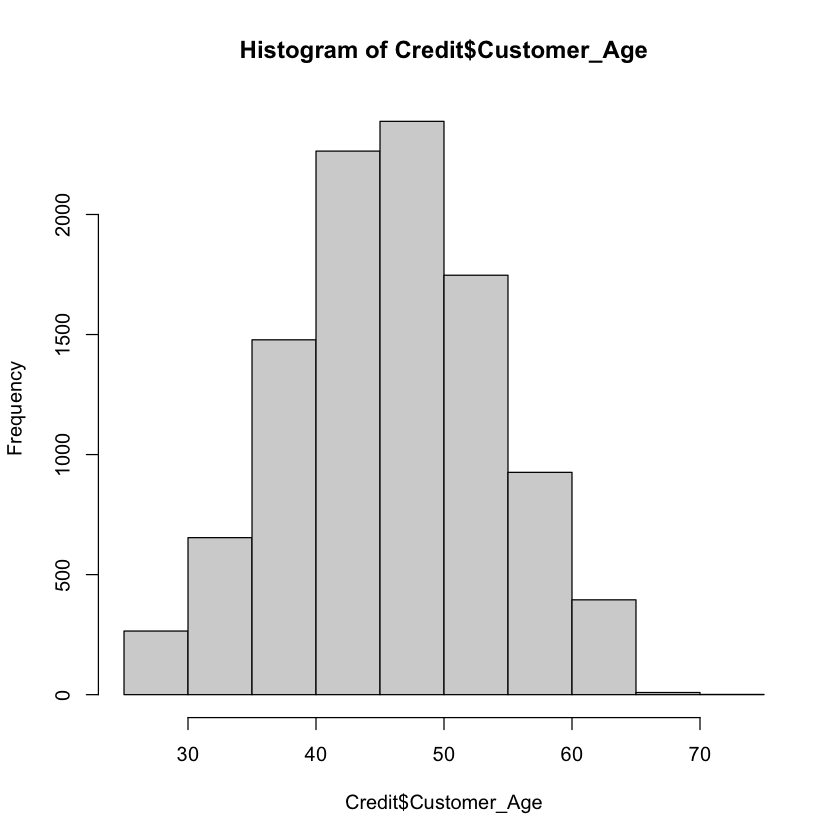

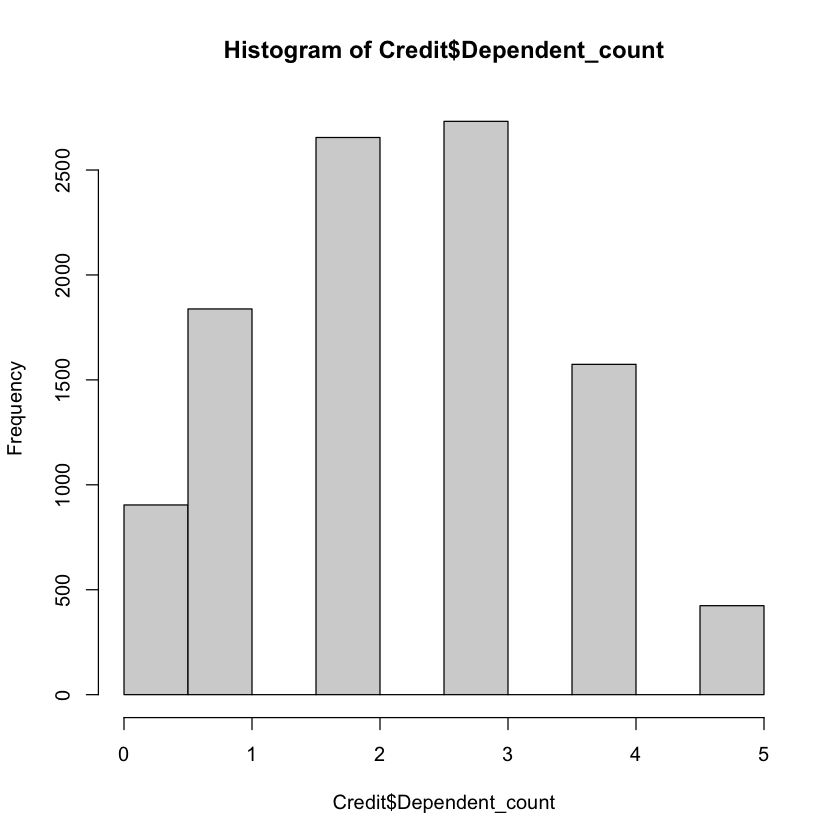

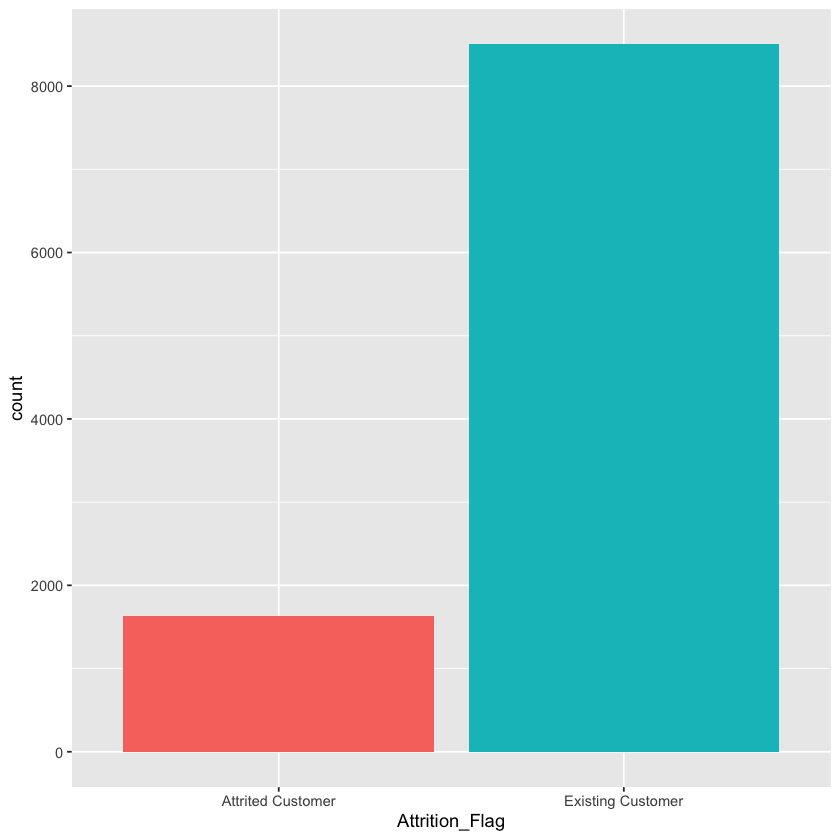

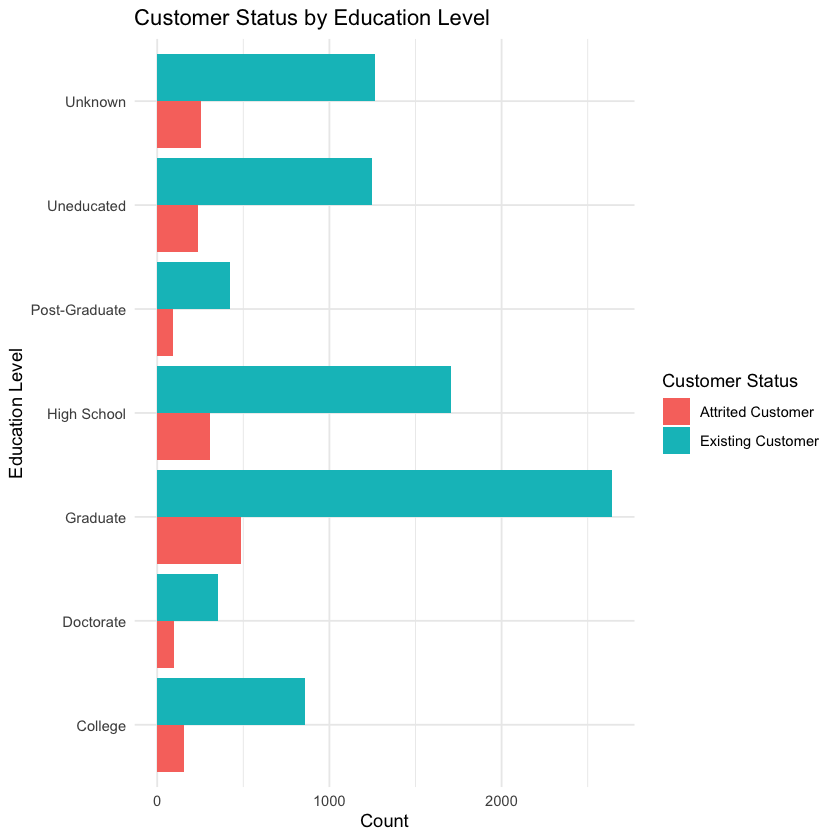

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


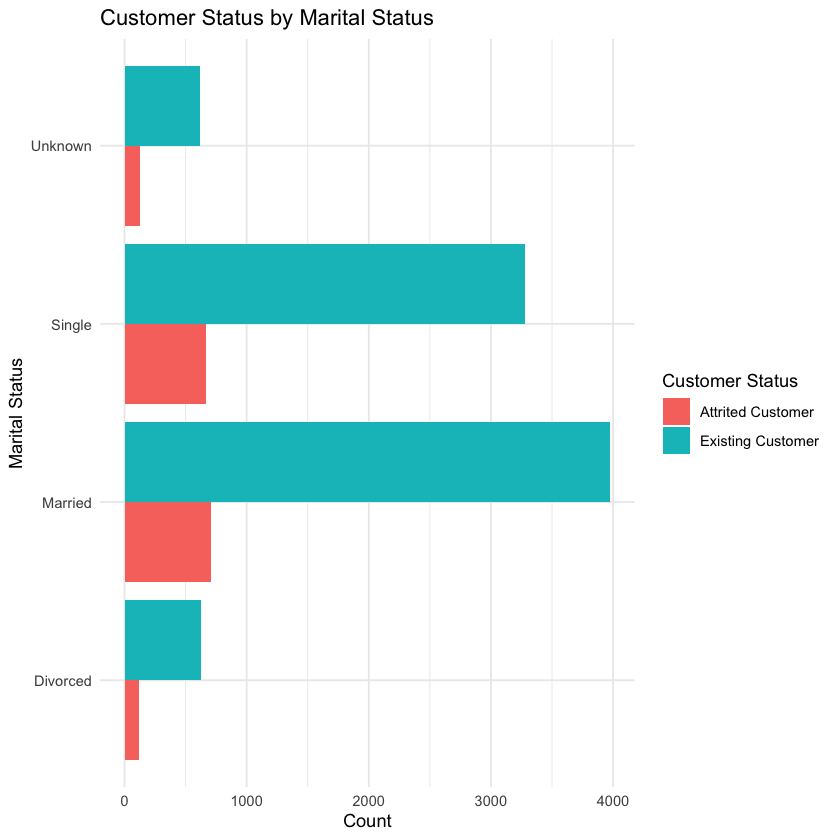

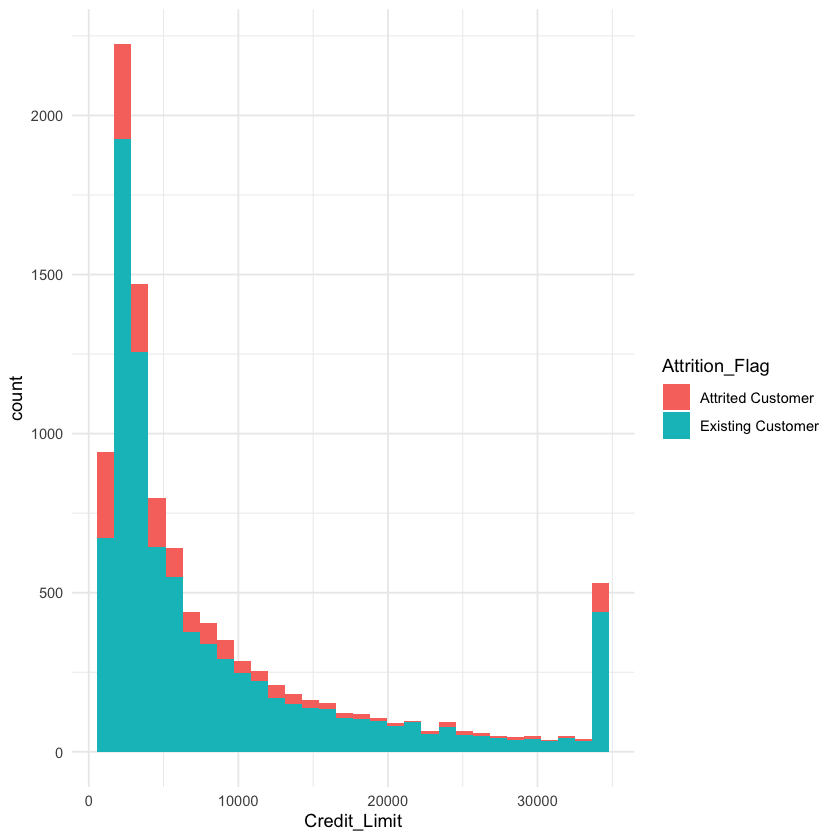

In [4]:
#separating numeric data into another variable
numericData<-(Credit ~-Credit$Attrition_Flag-Credit$Gender-Credit$Education_Level
            -Credit$Marital_Status-Credit$Income_Category-Credit$Card_Category)

#correlation chart
#corrplot(numericData)
#pairs(numericData)

#eda charts
hist(Credit$Customer_Age)
hist(Credit$Dependent_count)
ggplot(Credit, aes(Attrition_Flag, fill = Attrition_Flag)) +geom_bar() +theme(legend.position = 'none')
ggplot(Credit, aes(y=Education_Level))+geom_bar(aes(fill =Attrition_Flag),position = "dodge")+xlab("Count") + ylab("Education Level") + ggtitle("Customer Status by Education Level" )+  labs(fill = "Customer Status") + theme_minimal()
ggplot(Credit, aes(y=Marital_Status))+geom_bar(aes(fill =Attrition_Flag),position = "dodge")+xlab("Count") + ylab("Marital Status") + ggtitle("Customer Status by Marital Status" )+  labs(fill = "Customer Status") + theme_minimal()
ggplot(Credit, aes(x=Credit_Limit, fill = Attrition_Flag)) + geom_histogram() + theme_minimal() + scale_x_continuous(breaks = seq(0,50000, by=10000))

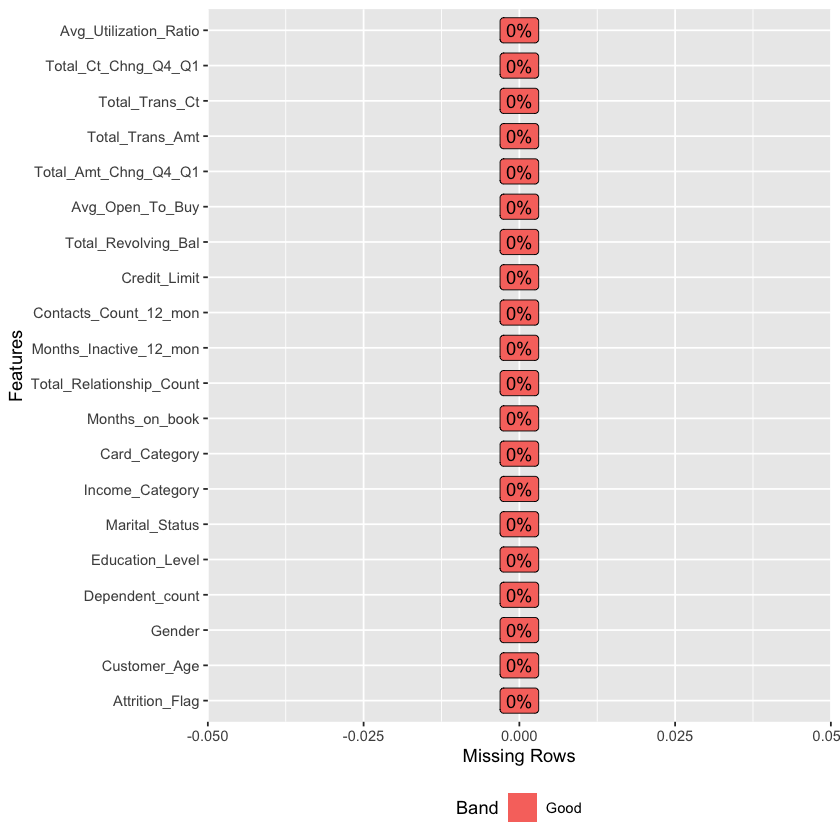

In [5]:
#Identify any missing data or errors in your data

plot_missing(Credit)

In [6]:
#using caret to spilt data into testing and training
set.seed(1234)
trainIndex <- createDataPartition(Credit$Attrition_Flag, p = .7,list=FALSE)
training <- Credit[trainIndex,]
testing <- Credit[-trainIndex,]

In [7]:
#-------------Dummy coding Dataset For Linear and Logistic Regression--------

#traning data
CreditNumTr <- dummy_cols(training)
CreditNumTr$Attrition_Flag<-ifelse(CreditNumTr$Attrition_Flag == "Existing Customer",1,0) 

#testdata
CreditNumTe <- dummy_cols(testing)
CreditNumTe$Attrition_Flag<-ifelse(CreditNumTe$Attrition_Flag == "Existing Customer",1,0) 
CreditNumTes<-subset(CreditNumTe,select=-c(CreditNumTe$Gender,CreditNumTe$Education_Level,
                    CreditNumTe$Marital_Status,CreditNumTe$Income_Category,CreditNumTe$Card_Category
                    ,CreditNumTe$`Attrition_Flag_Attrited Customer`
                    ,CreditNumTe$`Attrition_Flag_Existing Customer`))

In [8]:
#--------------Linear Regression--------------

In [9]:
#creating model removing categorical columns
lrmodel<-lm(Attrition_Flag ~.-Gender-Education_Level-Marital_Status-Income_Category
            -Card_Category-`Attrition_Flag_Attrited Customer`
            -`Attrition_Flag_Existing Customer`,CreditNumTr)
summary(lrmodel)
problm <- predict.lm(lrmodel,data=CreditNumTes,type="response")
confusionMatrix(reference=as.factor(problm),data = as.factor(CreditNumTes$Attrition_Flag))
summary(problm)


Call:
lm(formula = Attrition_Flag ~ . - Gender - Education_Level - 
    Marital_Status - Income_Category - Card_Category - `Attrition_Flag_Attrited Customer` - 
    `Attrition_Flag_Existing Customer`, data = CreditNumTr)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.16396 -0.10995  0.05133  0.18881  0.86303 

Coefficients: (6 not defined because of singularities)
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       9.449e-03  4.461e-02   0.212 0.832250    
Customer_Age                      7.189e-04  7.105e-04   1.012 0.311683    
Dependent_count                  -9.767e-03  2.707e-03  -3.608 0.000311 ***
Months_on_book                   -2.224e-04  7.052e-04  -0.315 0.752549    
Total_Relationship_Count          4.382e-02  2.405e-03  18.221  < 2e-16 ***
Months_Inactive_12_mon           -4.419e-02  3.454e-03 -12.794  < 2e-16 ***
Contacts_Count_12_mon            -4.026e-02  3.177e-03 -12.674  < 2e-16 ***
Credit_Lim

ERROR: Error in confusionMatrix.default(reference = as.factor(problm), data = as.factor(CreditNumTes$Attrition_Flag)): The data must contain some levels that overlap the reference.


In [10]:
#--------------Logistic Regression-------------

In [11]:
lormodel<-glm(Attrition_Flag ~.-Gender-Education_Level-Marital_Status-Income_Category
            -Card_Category-`Attrition_Flag_Attrited Customer`
            -`Attrition_Flag_Existing Customer`,CreditNumTr,family="binomial")
summary(lormodel)

problom <- predict.glm(lormodel,data=CreditNumTes,type="response")
confusionMatrix(problom,as.factor(CreditNumTes$Attrition_Flag))
summary(problom)


Call:
glm(formula = Attrition_Flag ~ . - Gender - Education_Level - 
    Marital_Status - Income_Category - Card_Category - `Attrition_Flag_Attrited Customer` - 
    `Attrition_Flag_Existing Customer`, family = "binomial", 
    data = CreditNumTr)

Coefficients: (6 not defined because of singularities)
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -5.425e+00  5.699e-01  -9.520  < 2e-16 ***
Customer_Age                      1.101e-02  9.198e-03   1.197  0.23149    
Dependent_count                  -1.028e-01  3.586e-02  -2.867  0.00414 ** 
Months_on_book                   -2.709e-03  9.156e-03  -0.296  0.76735    
Total_Relationship_Count          4.739e-01  3.308e-02  14.327  < 2e-16 ***
Months_Inactive_12_mon           -5.353e-01  4.552e-02 -11.760  < 2e-16 ***
Contacts_Count_12_mon            -5.089e-01  4.319e-02 -11.782  < 2e-16 ***
Credit_Limit                      1.914e-05  8.149e-06   2.349  0.01883 *  
Total_Revol

ERROR: Error: `data` and `reference` should be factors with the same levels.


In [ ]:
#--------------Decision Tree--------------

In [19]:
#create tree
hit.rtree<-rpart(Attrition_Flag ~., data=training, method="class")

#summarize full tree (no pruning)
summary(hit.rtree)

Call:
rpart(formula = Attrition_Flag ~ ., data = training, method = "class")
  n= 7089 

           CP nsplit rel error    xerror       xstd
1  0.16681299      0 1.0000000 1.0000000 0.02714589
2  0.07199298      2 0.6663740 0.6725198 0.02294879
3  0.03994732      3 0.5943810 0.6005268 0.02182586
4  0.02897278      5 0.5144864 0.5329236 0.02068391
5  0.01843723      6 0.4855136 0.5162423 0.02038743
6  0.01492537      9 0.4214223 0.4477612 0.01910068
7  0.01141352     10 0.4064969 0.4398595 0.01894434
8  0.01097454     11 0.3950834 0.4354697 0.01885672
9  0.01053556     13 0.3731343 0.4354697 0.01885672
10 0.01000000     15 0.3520632 0.4284460 0.01871538

Variable importance
          Total_Trans_Ct          Total_Trans_Amt      Total_Revolving_Bal 
                      25                       19                       14 
   Avg_Utilization_Ratio      Total_Ct_Chng_Q4_Q1 Total_Relationship_Count 
                      13                        9                        8 
            Cr

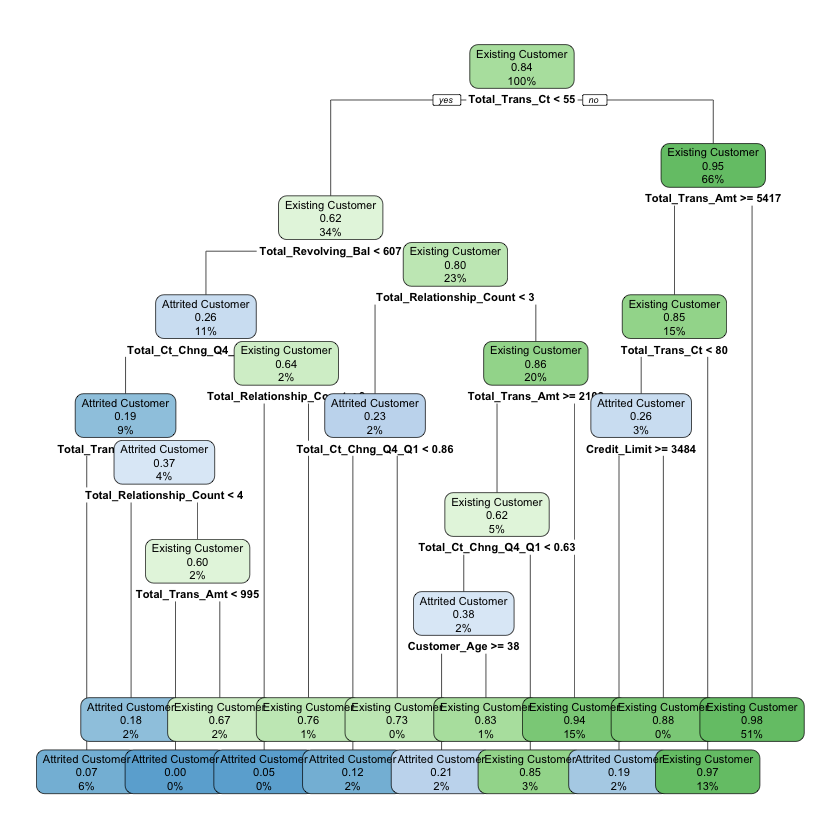

In [20]:
#Readable Plot using rpart.plot
rpart.plot(hit.rtree,tweak=1.5,box.palette="auto")


Classification tree:
rpart(formula = Attrition_Flag ~ ., data = training, method = "class")

Variables actually used in tree construction:
[1] Credit_Limit             Customer_Age             Total_Ct_Chng_Q4_Q1     
[4] Total_Relationship_Count Total_Revolving_Bal      Total_Trans_Amt         
[7] Total_Trans_Ct          

Root node error: 1139/7089 = 0.16067

n= 7089 

         CP nsplit rel error  xerror     xstd
1  0.166813      0   1.00000 1.00000 0.027146
2  0.071993      2   0.66637 0.67252 0.022949
3  0.039947      3   0.59438 0.60053 0.021826
4  0.028973      5   0.51449 0.53292 0.020684
5  0.018437      6   0.48551 0.51624 0.020387
6  0.014925      9   0.42142 0.44776 0.019101
7  0.011414     10   0.40650 0.43986 0.018944
8  0.010975     11   0.39508 0.43547 0.018857
9  0.010536     13   0.37313 0.43547 0.018857
10 0.010000     15   0.35206 0.42845 0.018715


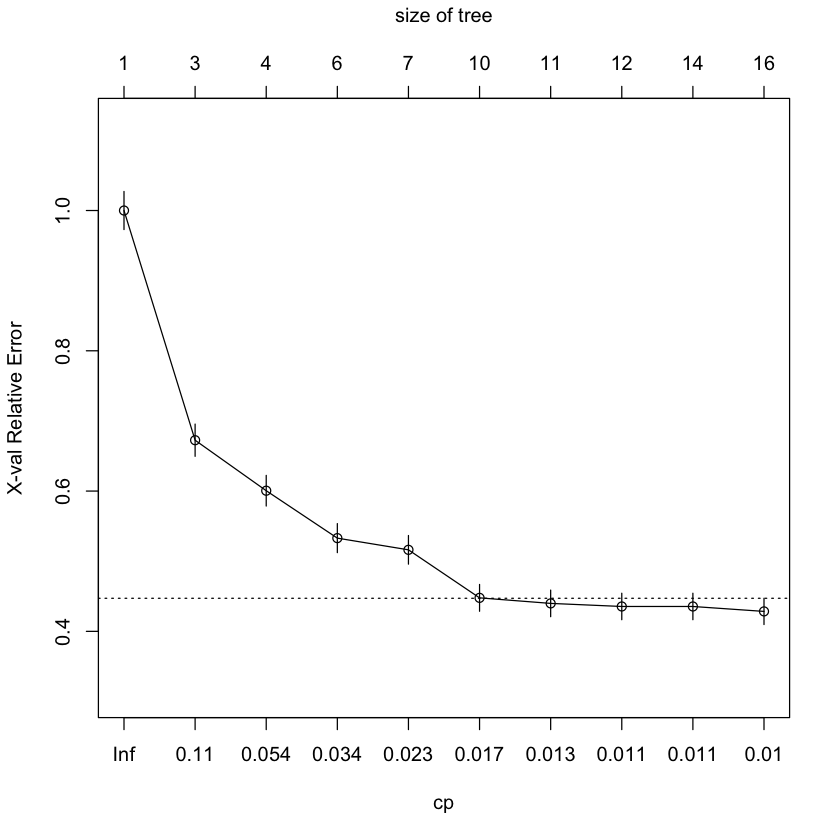

In [21]:
#Attempting Pruning
printcp(hit.rtree) #display crossvalidated error for each tree size
plotcp(hit.rtree) #plot cv error

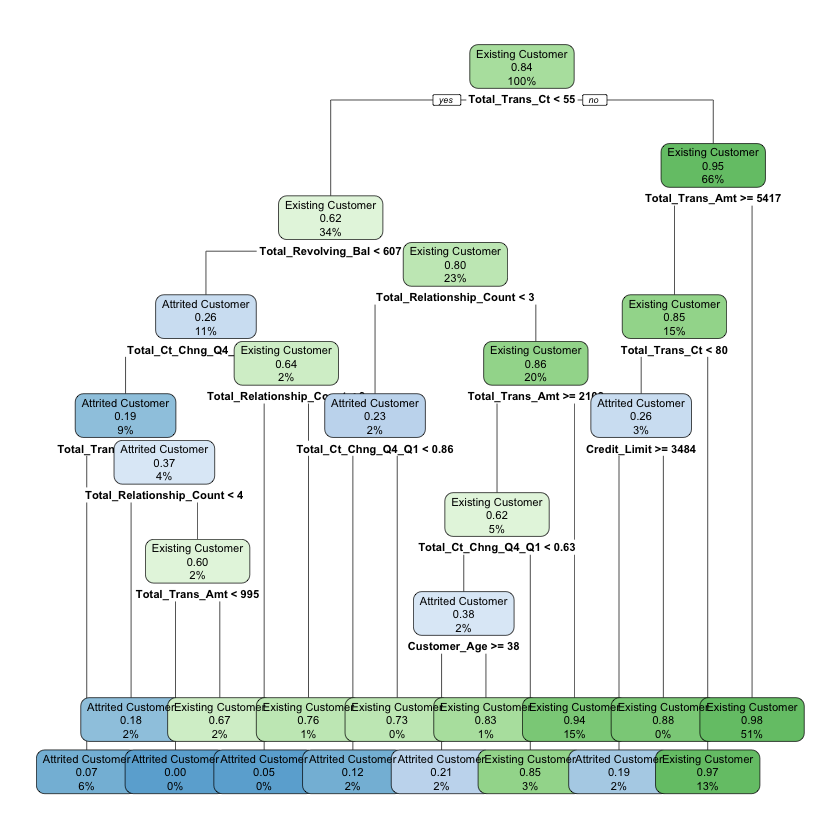

In [22]:
#select CP with lowest crossvalidated error
#we can grab this from the plotcp table automatically with 
opt.cp <- hit.rtree$cptable[which.min(hit.rtree$cptable[,"xerror"]),"CP"]
hit.rtree.pruned <- prune(hit.rtree, cp=opt.cp)
rpart.plot(hit.rtree.pruned,tweak=1.5,box.palette="auto")

In [23]:
#list out variables in order of importance
varImp(hit.rtree)
varImp(hit.rtree.pruned)

Overall   
Avg_Open_To_Buy           13.662996
Avg_Utilization_Ratio    517.705148
Contacts_Count_12_mon     30.878416
Credit_Limit              14.640642
Customer_Age              59.974279
Education_Level            3.424205
Gender                    16.818737
Marital_Status            20.738352
Months_Inactive_12_mon    54.640255
Months_on_book            23.552656
Total_Amt_Chng_Q4_Q1     143.127900
Total_Ct_Chng_Q4_Q1      613.697790
Total_Relationship_Count 395.817364
Total_Revolving_Bal      767.291567
Total_Trans_Amt          776.245669
Total_Trans_Ct           564.115521
Dependent_count            0.000000
Income_Category            0.000000
Card_Category              0.000000

Overall   
Avg_Open_To_Buy           13.662996
Avg_Utilization_Ratio    517.705148
Contacts_Count_12_mon     30.878416
Credit_Limit              14.640642
Customer_Age              59.974279
Education_Level            3.424205
Gender                    16.818737
Marital_Status            20.738352
Months_Inactive_12_mon    54.640255
Months_on_book            23.552656
Total_Amt_Chng_Q4_Q1     143.127900
Total_Ct_Chng_Q4_Q1      613.697790
Total_Relationship_Count 395.817364
Total_Revolving_Bal      767.291567
Total_Trans_Amt          776.245669
Total_Trans_Ct           564.115521
Dependent_count            0.000000
Income_Category            0.000000
Card_Category              0.000000

In [26]:
#using testing data to measure accuracy
probt <- predict(hit.rtree,data=testing,type="class")
confusionMatrix(data=probt,testing$Attrition_Flag)
summary(probt)

ERROR: Error in table(data, reference, dnn = dnn, ...): all arguments must have the same length


In [27]:
#----------------Bagging Tree-----------------

In [28]:
gbag <- bagging(Attrition_Flag ~ ., data = training, coob=TRUE)
varImp((gbag))
probbag <- predict(gbag,testing,type="class")
cm<-confusionMatrix(probbag,testing$Attrition_Flag)
summary(gbag)
attributes(gbag$class)
plot(gbag$mtrees,gbag$btree)
attributes(probbag)
summary(gbag$gbag)
summary(confusionMatrix(probbag,testing$Attrition_Flag))
attributes(confusionMatrix(probbag,testing$Attrition_Flag))
attributes(cm$overall[1])

cm1<-list()

for(i in 10:50){
  gbag <- bagging(Attrition_Flag ~ ., data = training,nbagg=i, coob=TRUE)
  probbag <- predict(gbag,testing,type="class")
  cm<-confusionMatrix(probbag,testing$Attrition_Flag)
  cm1<-append(cm1,cm$overall[1])
}
plot(10:30,cm1, type = 'l', col=2, lwd=2,xlab = "Number of Trees",ylab="Accuracy")
boxplot(t(10:30), names=ntree, xlab="Number of Tree", ylab="Test MSE")
lines(apply(cm1, 1, mean), col="red", lty=2, lwd=2)

Overall   
Avg_Open_To_Buy           155.28566
Avg_Utilization_Ratio     609.68464
Card_Category              19.63499
Contacts_Count_12_mon     129.20772
Credit_Limit              161.54645
Customer_Age              214.00898
Dependent_count            69.78044
Education_Level           146.60878
Gender                     76.99403
Income_Category           124.82007
Marital_Status             83.09206
Months_Inactive_12_mon    136.76179
Months_on_book            157.37802
Total_Amt_Chng_Q4_Q1      406.43398
Total_Ct_Chng_Q4_Q1       820.79682
Total_Relationship_Count  496.31371
Total_Revolving_Bal       920.52722
Total_Trans_Amt          1030.13086
Total_Trans_Ct            729.83815


Bagging classification trees with 25 bootstrap replications 

Call: bagging.data.frame(formula = Attrition_Flag ~ ., data = training, 
    coob = TRUE)

Out-of-bag estimate of misclassification error:  0.0473 



$y
   [1] Existing Customer Existing Customer Existing Customer Existing Customer
   [5] Existing Customer Existing Customer Existing Customer Existing Customer
   [9] Existing Customer Existing Customer Existing Customer Existing Customer
  [13] Existing Customer Existing Customer Existing Customer Existing Customer
  [17] Existing Customer Existing Customer Existing Customer Existing Customer
  [21] Existing Customer Existing Customer Existing Customer Existing Customer
  [25] Existing Customer Existing Customer Existing Customer Existing Customer
  [29] Existing Customer Existing Customer Existing Customer Existing Customer
  [33] Attrited Customer Existing Customer Existing Customer Existing Customer
  [37] Existing Customer Existing Customer Existing Customer Existing Customer
  [41] Existing Customer Existing Customer Existing Customer Existing Customer
  [45] Existing Customer Existing Customer Existing Customer Existing Customer
  [49] Existing Customer Existing Customer Existi

NULL

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' is a list, but does not have components 'x' and 'y'
